Load V1 receptive fields from Ringach et. al. and compute covariance matrix

In [52]:
import numpy as np
import numpy.linalg as la
import glob
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
import h5py

In [2]:
dataroot = 'data/V1_data_Ringach/'
data = sio.loadmat(dataroot + 'rf_db.mat')['rf']
num_cells, dim = 250, 32 ** 2 # 250 cells with RF of size 32 x 32

In [3]:
# different cells have difference receptive field sizes (32 x 32, 64 x 64, 128 x 128). 
# Downsample them all to be 32 x 32.
STA = np.zeros((num_cells, dim))
time_to_peak = np.zeros(num_cells)
d2p = np.zeros(num_cells)

for cell in range(num_cells):
    s = data[0][cell][0]
    resize_factor = int(s.shape[0] / 32)
    s_scaled = downscale_local_mean(s, (resize_factor, resize_factor))
    STA[cell] = s_scaled.flatten()
    time_to_peak[cell] = data[0][cell][1]
    d2p[cell] = data[0][cell][2]

In [4]:
# pre-processing
from skimage.measure import regionprops
STA = (STA - np.mean(STA, axis=1).reshape(-1, 1)) / np.std(STA, axis=1).reshape(-1, 1)

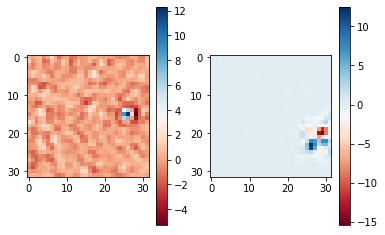

In [200]:
# plot STAs from data and modeled
from estimator import V1_inspired_weights_same_center, V1_inspired_weights
# W = V1_inspired_weights_same_center(num_cells, dim, 2, 3, (14, 14))
W = V1_inspired_weights(num_cells, dim, 3, 1)

i = np.random.randint(250)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(121)
plt.imshow(STA[i].reshape(32, 32), cmap='RdBu')
plt.colorbar()

ax = fig.add_subplot(122)
plt.imshow(W[i].reshape(32, 32), cmap='RdBu')
plt.colorbar()

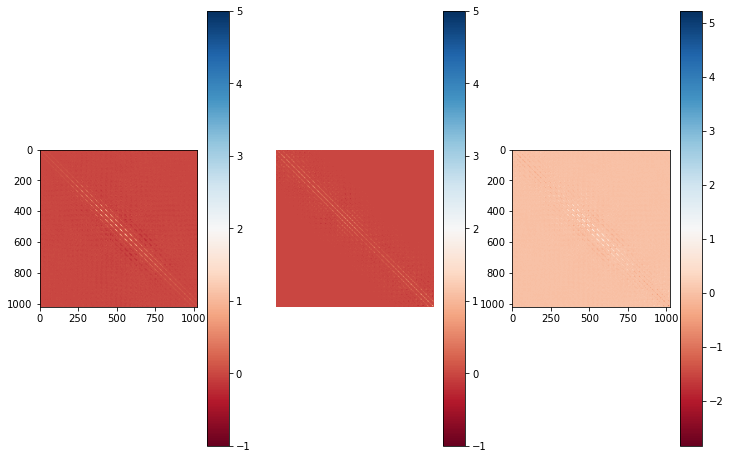

In [204]:
from estimator import V1_inspired_weights, V1_inspired_kernel_matrix
C = W.T @ W
C *= dim / np.trace(C)
# C = V1_inspired_kernel_matrix(1024, 3, 1, (16, 16), scale=1)

C_data = STA.T @ STA
C_data *= dim / np.trace(C_data)


cmap_lim = 5
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.imshow(C_data, cmap='RdBu')
plt.clim(-1, 5)
# plt.axis('off')
plt.colorbar()

ax = fig.add_subplot(132)
plt.imshow(C, cmap='RdBu')
plt.clim(-1, 5)
plt.axis('off')
plt.colorbar()

ax = fig.add_subplot(133)
plt.imshow(C_data - C, cmap='RdBu')
# plt.clim(-1, 5)
# plt.axis('off')
plt.colorbar()

2.8332681160944095